In [22]:
from pandas import read_csv
from matplotlib import pyplot

dataset = read_csv('ppidp_waits_node2.csv', header=0, index_col=0)
dataset.index.name = 'date'

print (dataset.head(1)) 

               HostCPUUtilization%_NODE2  AverageActiveSessions_NODE2  \
date                                                                    
4/28/21 13:00                        2.5                          0.8   

               MemoryUtilization%_NODE2  CPU  USER_IO  APPLICATION   GC  \
date                                                                      
4/28/21 13:00                        52  0.0      0.0          0.0  0.0   

               CONCURRENCY  NETWORK  SYSTEM_IO  ADMIN  CONFIG  CMMIT  \
date                                                                   
4/28/21 13:00          0.0      0.0        0.0    0.0     0.0    0.0   

               SCHEDULER  OTHER  TOTAL  
date                                    
4/28/21 13:00          0    0.0    0.0  


In [23]:
values = dataset.values

# ensure all data is float
values = values.astype('float32')

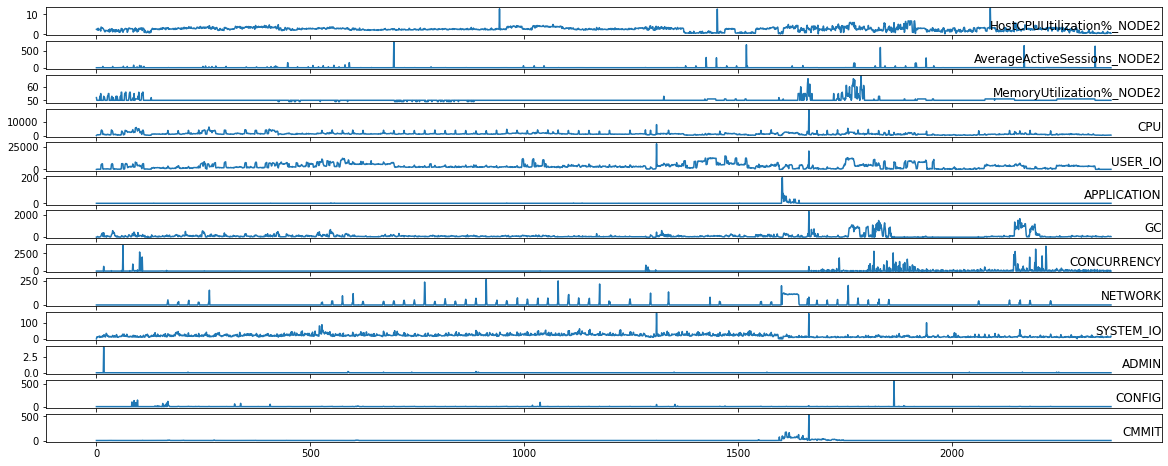

In [24]:
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
i = 1
# plot each column
pyplot.figure(figsize=(20, 8))

for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=.01, loc='right')
	i += 1
pyplot.show()

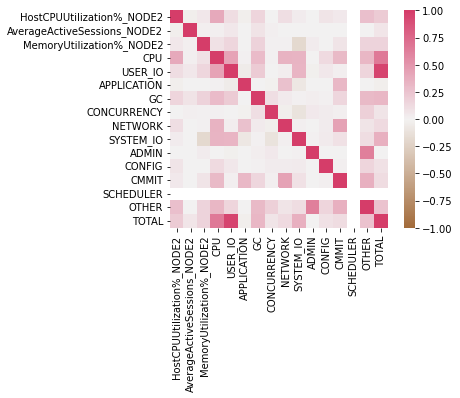

In [25]:
import seaborn as sns

correlation_dataset = dataset.corr()

axis_corr = sns.heatmap(
correlation_dataset,
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(400000, 990000, n=900000),
square=True
)

pyplot.show()

In [26]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [27]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[   17, 18, 19, 20, 21, 22, 23, 24, 25,26, 27,28,29,30,31]], axis=1, inplace=True)
print(reframed.head(1))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.179688   0.001052   0.157895        0.0        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1        0.0        0.0        0.0         0.0         0.0         0.0   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)   var1(t)  
1         0.0         0.0         0.0         0.0  0.171875  


In [28]:
# split into train and test sets
values = reframed.values
n_train_hours = 2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 1, 16) (2000,) (371, 1, 16) (371,)


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1834 - val_loss: 0.0872
Epoch 2/10
1/1 [==============================] - 0s 213ms/step - loss: 0.1101 - val_loss: 0.0625
Epoch 3/10
1/1 [==============================] - 0s 243ms/step - loss: 0.0508 - val_loss: 0.0970
Epoch 4/10
1/1 [==============================] - 0s 216ms/step - loss: 0.0882 - val_loss: 0.1037
Epoch 5/10
1/1 [==============================] - 0s 232ms/step - loss: 0.0953 - val_loss: 0.0842
Epoch 6/10
1/1 [==============================] - 0s 242ms/step - loss: 0.0727 - val_loss: 0.0651
Epoch 7/10
1/1 [==============================] - 0s 198ms/step - loss: 0.0500 - val_loss: 0.0602
Epoch 8/10
1/1 [==============================] - 0s 202ms/step - loss: 0.0512 - val_loss: 0.0611
Epoch 9/10
1/1 [==============================] - 0s 202ms/step - loss: 0.0635 - val_loss: 0.0617
Epoch 10/10
1/1 [==============================] - 0s 193ms/step - loss: 0.0675 - val_loss: 0.0607


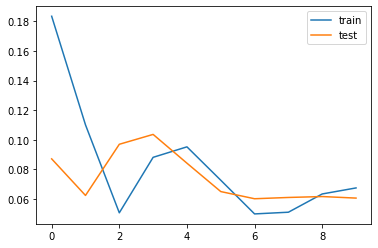

In [29]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(664, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(120))
model.add(Dense(62))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
#model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=2000, validation_data=(test_X, test_y), verbose=1, shuffle=False)
#history = model.fit(train_X, train_y, epochs=1000, batch_size=130, validation_data=(train_X, train_y), verbose=0, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

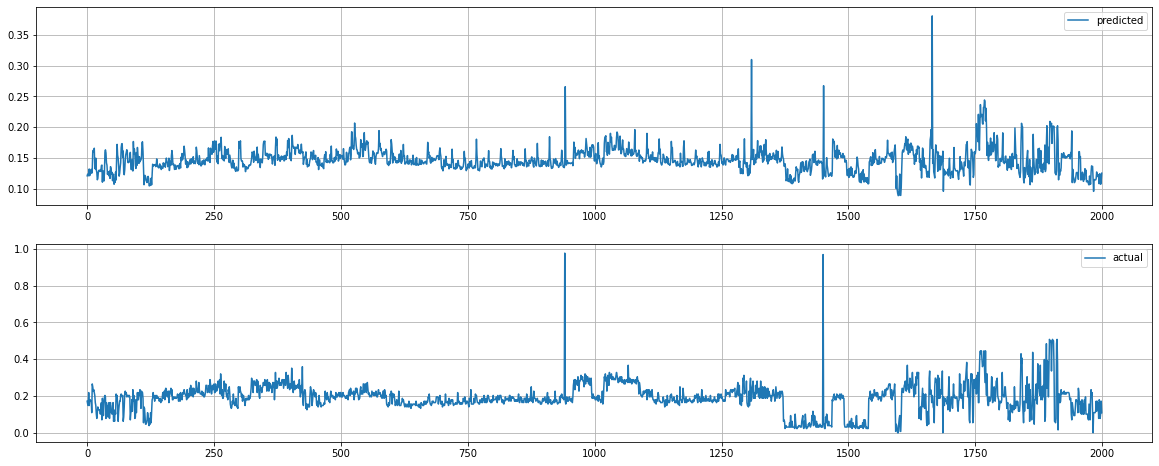

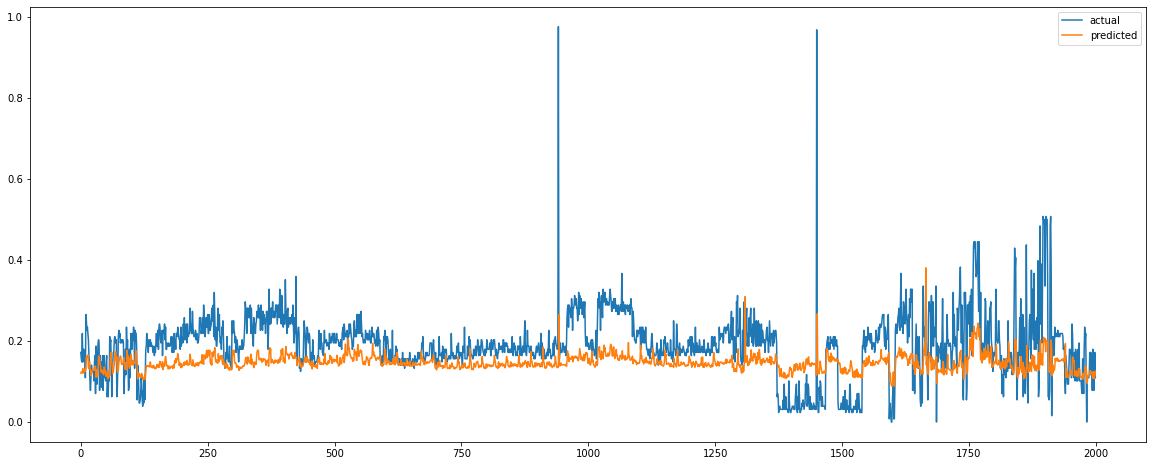

In [36]:
yhat = model.predict(train_X)

pyplot.figure(figsize=(20, 8))                # the first figure
pyplot.subplot(211)             # the first subplot in the first figure
pyplot.plot(yhat, label='predicted')
pyplot.grid(True)
pyplot.legend()
pyplot.subplot(212)             # the second subplot in the first figure
pyplot.plot(train_y, label='actual')
pyplot.grid(True)
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(20, 8))
pyplot.plot(train_y[:], label='actual')
pyplot.plot(yhat[:],  label='predicted')
pyplot.legend()
pyplot.show()

In [34]:
#!pip install shap  # If this doesn't work, do "pip install shap" from Jupyter notebook terminal
import pkg_resources
pkg_resources.require("numpy==1.20.2")
# import shap library
#import shap
import numpy
print(numpy.__version__)
# we use the first 100 training examples as our background dataset to integrate over
print(shap._version_)
explainer = shap.DeepExplainer(model, train_X)

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(test_X)




VersionConflict: (numpy 1.22.2 (c:\users\amali\appdata\roaming\python\python39\site-packages), Requirement.parse('numpy==1.20.2'))